### Imports

In [20]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import seaborn as sns

sns.set_theme(style='ticks')
sns.set_context('paper')

# from pycaret.regression import *

In [21]:
# plot two features against each other
def plot_jointplot(data, x, y):
    r, p = sp.stats.pearsonr(data[x], data[y])

    jgrid = sns.jointplot(data=data, x=x, y=y, kind='reg')
    jgrid.ax_joint.text(
        1, 1, 
        f"r={r:.2f}, p={p:.2e}",
        horizontalalignment='right',
        transform = jgrid.ax_joint.transAxes
    )

    jgrid.figure.show()

In [22]:
data = gpd.read_file('../GENERATED-DATA/data_by_zone.geojson')
data.shape

(342, 78)

### Plots

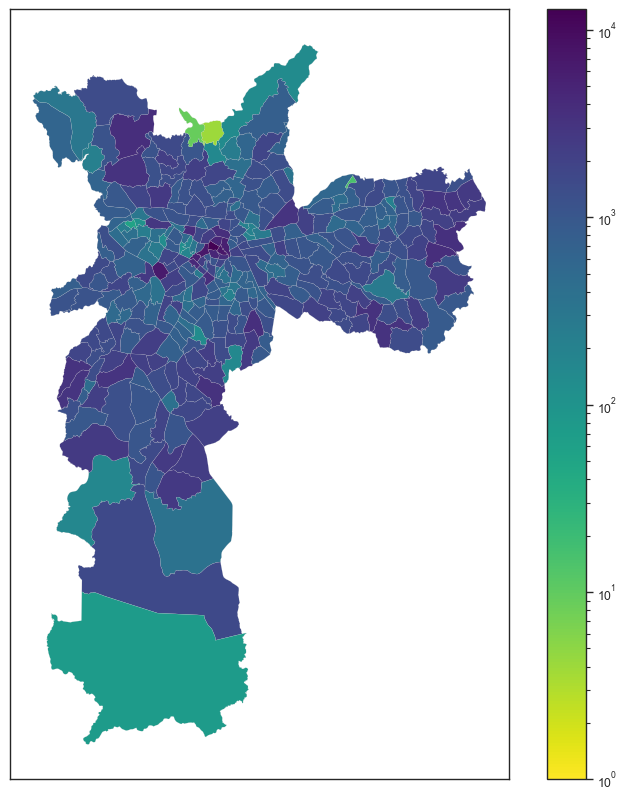

In [127]:
data.plot(
    column='crimes',
    legend=True,
    linewidth=0.1,
    edgecolor='0.8',
    figsize=(10, 10),
    cmap='viridis_r',
    norm=LogNorm(vmin=1, vmax=data['crimes'].max()),
)

plt.xticks([])
plt.yticks([])

plt.show()


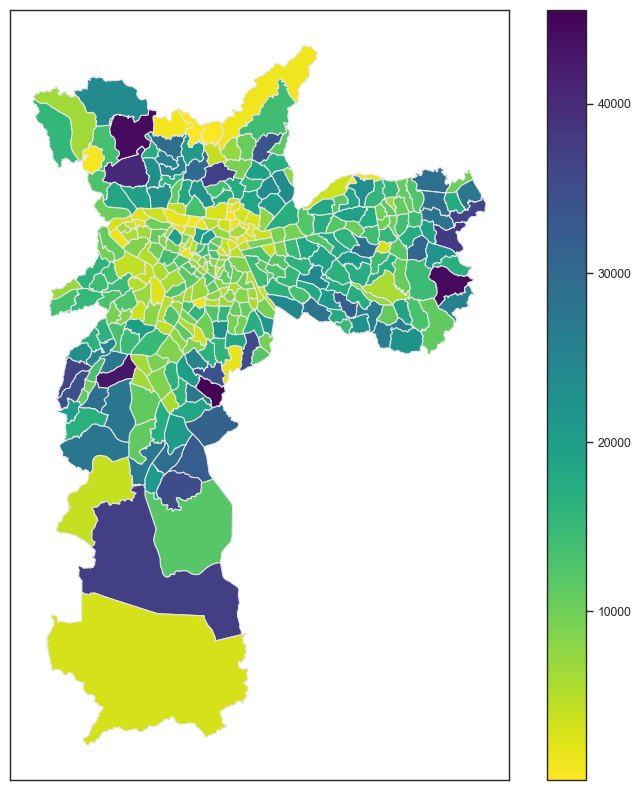

In [134]:
data.plot(
    column='V001_BASICO',
    legend=True,
    linewidth=0.8,
    edgecolor='0.9',
    figsize=(10, 10),
    cmap='viridis_r',
)

plt.xticks([])
plt.yticks([])

plt.show()


### Exploring the connection between crime and other variables

#### CENSUS Variables

In [16]:
df = data[[
    'Area_ha_2', 'V001_ENTORNO01', 'V002_ENTORNO01', 'V003_ENTORNO01',
    'V004_ENTORNO01', 'V001_DOMICILIORENDA', 'V001_BASICO', 'V002_BASICO',
    'V001_DOMICILIO02', 'V002_DOMICILIO02', 'V001_DOMICILIO01',
    'V002_DOMICILIO01', 'V001_PESSOA01', 'V086_PESSOA02', 'V001_PESSOA03',
    'V002_PESSOA03', 'V003_PESSOA03', 'V004_PESSOA03', 'V005_PESSOA03',
    'V006_PESSOA03', 'V001_PESSOA12', 'V001_PESSOA11', 'V001_RESPONSAVEL01',
    'V001_RESPONSAVEL02', 'V002_DOMICILIORENDA', 'V003_DOMICILIORENDA',
    'V004_DOMICILIORENDA', 'V003_BASICO', 'V005_BASICO', 'V007_BASICO',
    'V009_BASICO', 'V011_BASICO', 'crimes'
]]

df.shape

(342, 33)

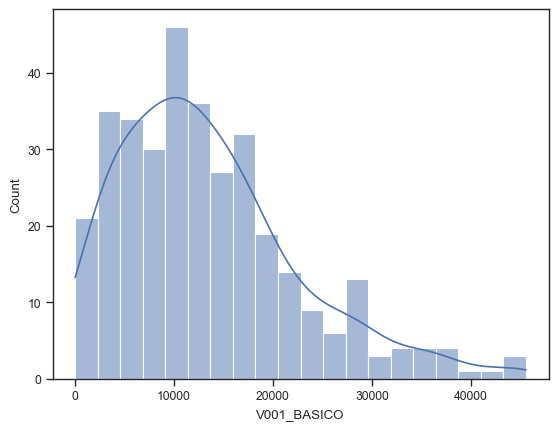

In [17]:
ax = sns.histplot(data=df, x='V001_BASICO', bins=20, kde=True)

C:\Users\arthu\AppData\Local\Temp\ipykernel_15068\825853075.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  jgrid.figure.show()


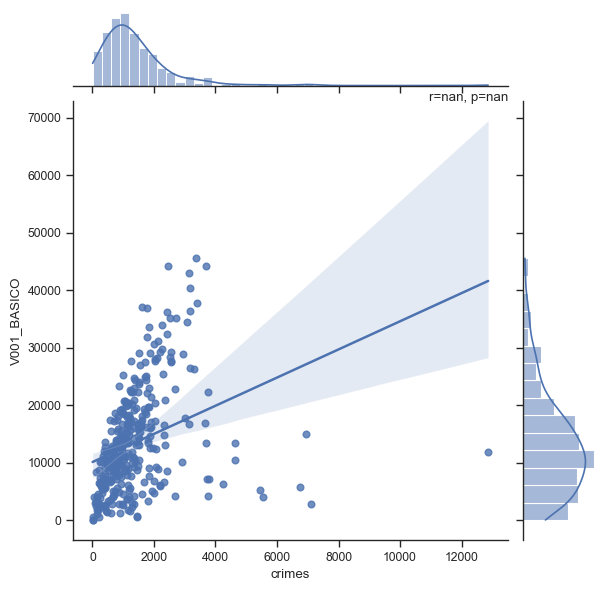

In [18]:
plot_jointplot(df, 'crimes', 'V001_BASICO')

<Axes: xlabel='crimes'>

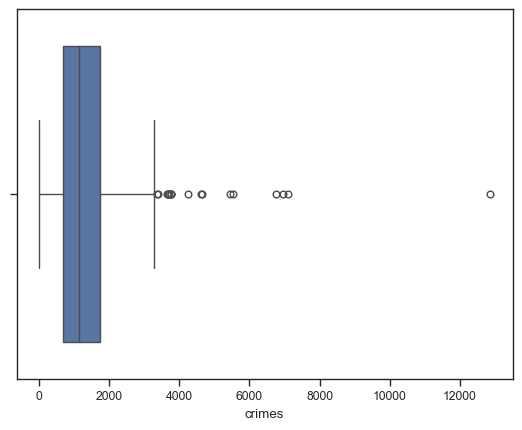

In [19]:
sns.boxplot(data=df, x='crimes')

In [20]:
# remove outliers based on the IQR
Q1 = df['crimes'].quantile(0.25)
Q3 = df['crimes'].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df['crimes'] < (Q1 - 1.5 * IQR)) | (df['crimes'] > (Q3 + 1.5 * IQR)))]

C:\Users\arthu\AppData\Local\Temp\ipykernel_15068\825853075.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  jgrid.figure.show()


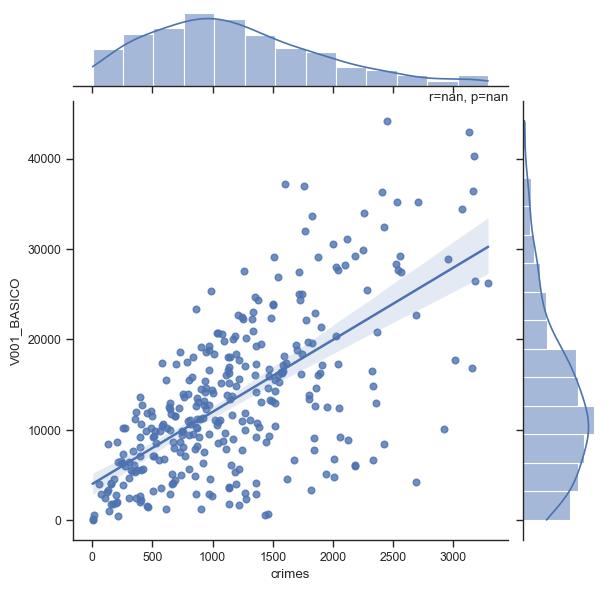

In [21]:
plot_jointplot(df, 'crimes', 'V001_BASICO')

In [22]:
# calcular pearson r for all features
corr_matrix = df.corr().abs()

# show as dataframe
corr_matrix['crimes'].sort_values(ascending=False).to_frame()[:10]

,crimes
crimes,1.000000
V001_DOMICILIO01,0.650906
V001_RESPONSAVEL02,0.650373
V002_DOMICILIO01,0.649702
V001_ENTORNO01,0.649702
V001_BASICO,0.649702
V001_RESPONSAVEL01,0.648125
V086_PESSOA02,0.643211
V001_PESSOA01,0.642189
V001_PESSOA03,0.640371


In [23]:
# it seems to be a lot of multicollinearity with V001_BASICO
# Domicílios particulares permanentes ou pessoas responsáveis por domicílios particulares permanentes

corr_matrix['V001_BASICO'].sort_values(ascending=False).to_frame()[:10]

,V001_BASICO
V001_ENTORNO01,1.000000
V002_DOMICILIO01,1.000000
V001_BASICO,1.000000
V001_RESPONSAVEL02,0.999986
V001_DOMICILIO01,0.999761
V001_PESSOA01,0.994179
V001_PESSOA12,0.992639
V001_RESPONSAVEL01,0.992600
V086_PESSOA02,0.991282
V001_PESSOA03,0.989884


In [24]:
df = df.loc[:, (df.columns == 'V001_BASICO') | (corr_matrix['V001_BASICO'] < 0.8)]

In [25]:
# calcular pearson r for all features
corr_matrix = df.corr().abs()

# show as dataframe
corr_matrix['crimes'].sort_values(ascending=False).to_frame()[:10]

,crimes
crimes,1.000000
V001_BASICO,0.649702
V003_ENTORNO01,0.334308
V005_BASICO,0.276927
V007_BASICO,0.271040
V002_DOMICILIORENDA,0.269395
V003_DOMICILIORENDA,0.269281
V011_BASICO,0.264608
V009_BASICO,0.260154
V006_PESSOA03,0.239055


<Axes: >

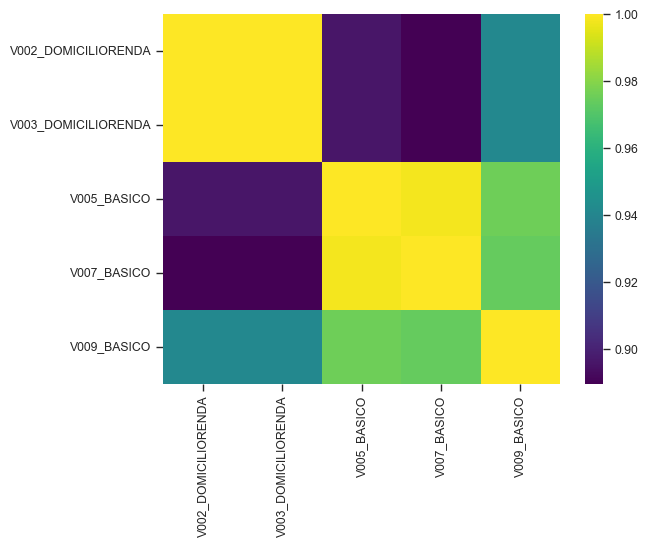

In [26]:
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

cols = (corr_matrix.mask(mask) > .8).any()
sns.heatmap(corr_matrix.loc[cols, cols], cmap='viridis')

In [27]:
# calcular pearson r for all features
corr_matrix = df.corr().abs()

# show as dataframe
corr_matrix['V005_BASICO'].sort_values(ascending=False).to_frame()[:10]

,V005_BASICO
V005_BASICO,1.000000
V007_BASICO,0.998263
V011_BASICO,0.989076
V009_BASICO,0.975675
V003_DOMICILIORENDA,0.896093
V002_DOMICILIORENDA,0.896049
V003_BASICO,0.612947
V003_ENTORNO01,0.395018
V001_BASICO,0.382838
crimes,0.276927


In [28]:
df = df.loc[:, (df.columns == 'V005_BASICO') | (corr_matrix['V005_BASICO'] < 0.8)]

In [29]:
df.columns

Index(['Area_ha_2', 'V003_ENTORNO01', 'V001_DOMICILIORENDA', 'V001_BASICO',
       'V004_PESSOA03', 'V006_PESSOA03', 'V004_DOMICILIORENDA', 'V003_BASICO',
       'V005_BASICO', 'crimes'],
      dtype='object')

### TPOT

In [122]:
import tpot 
from deap import creator

def tpot_models_dataframe(tpot_model):
    scores = {}
    for model, model_info in tpot_model.evaluated_individuals_.items():
        cv_score = model_info.get('internal_cv_score')
        scores[model] = cv_score

    scores = (
        pd.DataFrame.from_dict(
            scores,
            orient='index',
            columns=['cv_score']
        )
        .sort_values(
            by='cv_score',
            ascending=False
        )
        .reset_index(names='model')
    )

    return scores

def tpot_pipeline_from_string(tpot_model, pipeline_string):
    deap_pipeline = creator.Individual.from_string(pipeline_string, tpot_model._pset)
    sklearn_pipeline = tpot_model._toolbox.compile(expr=deap_pipeline)
    return sklearn_pipeline

In [139]:
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor

def compare_metric_with_dummy(model, score, X, y, cv):
    dummy = DummyRegressor(strategy='mean')

    cross_val_dummy = cross_val_score(
        dummy,
        X.values, y.values,
        cv=cv,
        scoring=score,
    )

    cross_val_model = cross_val_score(
        model,
        X.values, y.values,
        cv=cv,
        scoring=score,
    )

    df = pd.DataFrame()
    df['dummy_scores'] = cross_val_dummy
    df['model_scores'] = cross_val_model
    return df.sort_values(by='model_scores', ascending=False)


In [23]:
features_to_drop = [
    'NumeroZona',
    'NomeZona',
    'NumeroMuni',
    'NomeMunici',
    'NumDistrit',
    'NomeDistri',
    'geometry',
]

features = [feature for feature in data.columns.to_list() if feature not in features_to_drop]
data = data[features]
data.dropna(inplace=True)

In [24]:
data.to_csv('../GENERATED-DATA/data_by_zone.csv', index=False)

In [12]:
X = data.drop(columns='crimes')
y = data['crimes']

In [146]:
from tpot import TPOTRegressor
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(
    n_splits=10,
    n_repeats=3,
    random_state=123,
)

tpot_model = TPOTRegressor(
    max_time_mins=3,
    verbosity=3,
    random_state=123,
    cv=cv,
    scoring='r2',
    n_jobs=-1,
    warm_start=True,
    memory='auto',
    template='Selector-Transformer-Regressor',
)

tpot_model.fit(X, y)

Optimization Progress: 100%|██████████| 100/100 [04:38<00:00,  2.04s/pipeline] 

In [135]:
models = tpot_models_dataframe(tpot_model)
models.to_csv('../GENERATED-DATA/tpot_models.csv', index=False)
models[:10]

,model,cv_score
0,ExtraTreesRegressor(StandardScaler(RidgeCV(inp...,0.527207
1,"ExtraTreesRegressor(RidgeCV(input_matrix), Ext...",0.527207
2,"ExtraTreesRegressor(RidgeCV(input_matrix), Ext...",0.527207
3,"ExtraTreesRegressor(RidgeCV(input_matrix), Ext...",0.527207
4,"ExtraTreesRegressor(RidgeCV(input_matrix), Ext...",0.526681
5,"ExtraTreesRegressor(RidgeCV(input_matrix), Ext...",0.526681
6,"ExtraTreesRegressor(RidgeCV(input_matrix), Ext...",0.526549
7,ExtraTreesRegressor(RobustScaler(RidgeCV(input...,0.526549
8,ExtraTreesRegressor(ZeroCount(RidgeCV(input_ma...,0.526159
9,ExtraTreesRegressor(RobustScaler(ZeroCount(Rid...,0.526159


In [129]:
top_model = tpot_pipeline_from_string(tpot_model, models.model[0])
top_model

Pipeline(steps=[('stackingestimator', StackingEstimator(estimator=RidgeCV())),
                ('standardscaler', StandardScaler()),
                ('extratreesregressor',
                 ExtraTreesRegressor(max_features=0.35000000000000003,
                                     min_samples_leaf=4, min_samples_split=5,
                                     random_state=123))])

In [145]:
score = 'neg_mean_absolute_error'
df = compare_metric_with_dummy(top_model, score, X, y, cv)
df.abs().describe()

,dummy_scores,model_scores
count,30.000000,30.000000
mean,776.288760,477.786035
std,148.891078,104.242625
min,557.618778,281.996695
25%,672.372341,415.581293
50%,759.831366,459.765337
75%,822.729683,501.472954
max,1171.059211,694.974581


### Add Spacial Lag

In [ ]:
from pysal.lib import weights

knn = weights.KNN.from_dataframe(data, k=5) # k=5 -> 50%
wq  = weights.contiguity.Rook.from_dataframe(data)
w_kernel = weights.distance.Kernel.from_dataframe(data)

In [ ]:
f, axs = plt.subplots(figsize=(10, 10))

ax = data.plot(
    edgecolor="k", facecolor="w", ax=axs
)

knn.plot(
    data,
    ax=axs,
    edge_kws=dict(color="r", linestyle=":", linewidth=1),
    node_kws=dict(marker="")
)

axs.axis([-46.6, -46.8, -23.7, -23.6]);
axs.set_axis_off()

In [ ]:
gdf_lag = (
    data[features]
    .apply(
        lambda y: weights.spatial_lag.lag_spatial(wq, y)
    )
    .rename(
        columns=lambda c: "LAG_" + c
    )
)

In [ ]:
gdf_lag.shape

In [ ]:
gdf_lag.isna().sum()

In [ ]:
# data = data[features + ['crimes']].join(gdf_lag)
# data.columns